<a href="https://colab.research.google.com/github/zhanglab-aim/ucla-automl-workshop/blob/main/UCLA_AutoML_workshop_Day1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 1. Building CNNs to Model Genomic Sequences


Summary:
- understand how CNNs model genomic sequences
- build CNNs with keras and pytorch
- model evaluations and tuning


# 0.Software Installation

In [1]:
%load_ext tensorboard
%pip install -q pytorch-lightning==1.6.5 torchmetrics==0.11.0 amber-automl==0.1.5

In [2]:
#!git clone --quiet https://github.com/zj-zhang/AMBER.git
#!cd AMBER; python setup.py -q develop

In [3]:
!amber-cli config -b tensorflow_2
!amber-cli -v

Setting the default backend to "tensorflow_2".

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.

 █████╗ ███╗   ███╗██████╗ ███████╗██████╗ 
██╔══██╗████╗ ████║██╔══██╗██╔════╝██╔══██╗
███████║██╔████╔██║██████╔╝█████╗  ██████╔╝
██╔══██║██║╚██╔╝██║██╔══██╗██╔══╝  ██╔══██╗
██║  ██║██║ ╚═╝ ██║██████╔╝███████╗██║  ██║
╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚══════╝╚═╝  ╚═╝

Automated Modeling of Biological Evidence-based Research
Version 0.1.5


In [4]:
# download data file
! if [ ! -f "genomic_data.npz" ]; then wget https://raw.githubusercontent.com/zhanglab-aim/ucla-automl-workshop/main/assets/genomic_data.npz ; else echo "Found previously downloaded data" ; fi 

Found previously downloaded data


# 1.Load Data and Train-Test Split

In [5]:
import os
import numpy as np
from typing import List
from sklearn.model_selection import train_test_split

In [6]:
with np.load('genomic_data.npz') as store:
    x = store['x']
    y = store['y']
print(f"examine data shape: x={x.shape}, y={y.shape}")

examine data shape: x=(5000, 200, 4), y=(5000, 1)


In [7]:
x_trainvalid, x_test, y_trainvalid, y_test = train_test_split(x, y, test_size=0.2, random_state=777)
x_train, x_valid, y_train, y_valid = train_test_split(x_trainvalid, y_trainvalid, test_size=0.1, random_state=111)
print(f"after split, train={x_train.shape}, {y_train.shape}; valid={x_valid.shape}, {y_valid.shape}; test={x_test.shape}, {y_test.shape}")

after split, train=(3600, 200, 4), (3600, 1); valid=(400, 200, 4), (400, 1); test=(1000, 200, 4), (1000, 1)


In [8]:
# reproducibility
import random
import tensorflow as tf
import torch
import os
import numpy as np

def seed_everything(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    ## tensorflow
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    ## pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

seed_everything(777)

Random seed set as 777


# 2.Build a Convolutional Neural Network (CNN) Model using Tensorflow/Keras

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
model_tf = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(200, 4)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=7, strides=1, activation='relu', padding='same', name='conv_1'),
    tf.keras.layers.MaxPool1D(pool_size=4, padding='same', name='maxpool_1'),
    tf.keras.layers.GlobalAveragePooling1D(name='gap'),
    tf.keras.layers.Dense(units=1, activation='sigmoid', name='output')
])

model_tf.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['acc', tf.keras.metrics.AUC(curve='ROC', name='auroc')],
)

model_tf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv1D)             (None, 200, 32)           928       
                                                                 
 maxpool_1 (MaxPooling1D)    (None, 50, 32)            0         
                                                                 
 gap (GlobalAveragePooling1D  (None, 32)               0         
 )                                                               
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


In [11]:
os.makedirs("keras_logs", exist_ok=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard("./keras_logs", histogram_freq=1)

hist_tf = model_tf.fit(
    x_train, y_train, 
    validation_data=(x_valid, y_valid), 
    batch_size=64, 
    epochs=20, 
    callbacks=[tensorboard_callback],
    verbose=True
)

Epoch 1/20
57/57 [==============================] - 4s 37ms/step - loss: 0.6920 - acc: 0.5300 - auroc: 0.5345 - val_loss: 0.6844 - val_acc: 0.6625 - val_auroc: 0.7380
Epoch 2/20
57/57 [==============================] - 1s 26ms/step - loss: 0.6811 - acc: 0.5958 - auroc: 0.6391 - val_loss: 0.6746 - val_acc: 0.6850 - val_auroc: 0.7491
Epoch 3/20
57/57 [==============================] - 2s 30ms/step - loss: 0.6711 - acc: 0.6433 - auroc: 0.7034 - val_loss: 0.6648 - val_acc: 0.6825 - val_auroc: 0.7529
Epoch 4/20
57/57 [==============================] - 2s 26ms/step - loss: 0.6610 - acc: 0.6650 - auroc: 0.7290 - val_loss: 0.6561 - val_acc: 0.6500 - val_auroc: 0.7510
Epoch 5/20
57/57 [==============================] - 2s 30ms/step - loss: 0.6517 - acc: 0.6617 - auroc: 0.7358 - val_loss: 0.6463 - val_acc: 0.6550 - val_auroc: 0.7526
Epoch 6/20
57/57 [==============================] - 2s 26ms/step - loss: 0.6416 - acc: 0.6756 - auroc: 0.7465 - val_loss: 0.6360 - val_acc: 0.6925 - val_auroc: 0.755

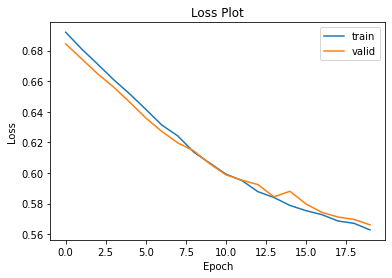

In [12]:
# check the loss plot
plt.plot(hist_tf.history['loss'])
plt.plot(hist_tf.history['val_loss'])
plt.title('Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'])
plt.show()

In [13]:
# uncomment to interactively visualize the results in Google Colab
#%tensorboard --logdir /content/keras_logs/

# 3.Build a CNN using Pytorch/Lightning

In [14]:
import torch
import pytorch_lightning as pl
import torchmetrics
from tqdm import tqdm

In [15]:
# make simple dataloaders
batch_size = 64
train_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

valid_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_valid), torch.Tensor(y_valid))
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)


In [16]:
# pytorch model class for a simple CNN
class ModelTorch(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # model
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=4, out_channels=32, kernel_size=7, padding='same'),
            torch.nn.ReLU())
        self.maxpool = torch.nn.MaxPool1d(kernel_size=4)
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(in_features=32, out_features=1),
            torch.nn.Sigmoid()
        )
        # loss and evaluation
        self.criterion = torch.nn.BCELoss()
        self.task = 'binary'
        self._metric_names = ['acc', 'auroc']
        self.train_metrics = [torchmetrics.Accuracy(task=self.task, average='macro'), torchmetrics.AUROC(task=self.task, average='macro')]
        self.test_metrics = [torchmetrics.Accuracy(task=self.task, average='macro'), torchmetrics.AUROC(task=self.task, average='macro')]
        # for checkpoint and reloading
        self.save_hyperparameters()

    def forward(self, x):
        # permute x dimensions to be (batch, feature, channel)
        x = torch.permute(x, (0,2,1))
        x = self.conv1(x)
        x = self.maxpool(x)
        # global average pooling
        x = torch.mean(x, dim=-1)
        # fully-connected
        out = self.fc(x)
        return out

    # below is required for pytorch-lightning training loop
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=0.001)
        return opt

    def step(self, batch, kind: str):
        x, y_true = batch
        y_hat = self.forward(x)
        total = y_true.size(0)
        loss = self.criterion(input=y_hat, target=y_true)
        batch_dict = {
            "loss": loss,
            "total": total,
        }
        # handle metrics
        metric_fns = self.train_metrics if kind == 'train' else self.test_metrics
        for metric, name in zip(metric_fns, self._metric_names):
            metric.update(preds=y_hat, target=y_true)
        return batch_dict
    
    def training_step(self, batch, batch_size) -> dict:
        return self.step(batch, "train")

    def validation_step(self, batch, batch_size) -> dict:
        return self.step(batch, "val")

    def test_step(self, batch, batch_size) -> dict:
        return self.step(batch, "test")
    
    def epoch_end(self, outputs: List[dict], kind: str):
        with torch.no_grad():
            # calculate average loss and average accuracy
            total_loss = sum(_["loss"] * _["total"] for _ in outputs)
            total = sum(_["total"] for _ in outputs)
            avg_loss = total_loss / total
            # calculate metrics
            metrics = self.train_metrics if kind == 'train' else self.test_metrics
            for metric, name in zip(metrics, self._metric_names):
                self.log(f"{kind}_{name}", metric.compute(), prog_bar=True)
                metric.reset()
        # log
        self.log(f"{kind}_loss", avg_loss, prog_bar=True)
    
    def training_epoch_end(self, outputs):
        self.epoch_end(outputs=outputs, kind='train')
    
    def validation_epoch_end(self, outputs):
        self.epoch_end(outputs=outputs, kind='valid')

    def test_epoch_end(self, outputs):
        self.epoch_end(outputs=outputs, kind='test')

In [17]:
# initialize a new model
model_torch = ModelTorch()

In [18]:
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model_torch, train_loader, valid_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params
-----------------------------------------
0 | conv1     | Sequential | 928   
1 | maxpool   | MaxPool1d  | 0     
2 | fc        | Sequential | 33    
3 | criterion | BCELoss    | 0     
-----------------------------------------
961       Trainable params
0         Non-trainable params
961       Total params
0.004     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [19]:
# uncomment to interactively visualize the results in Google Colab
#%tensorboard --logdir /content/lightning_logs/

# 4.Model Inference and Evaluation

Now we have two CNN models, implemented using two popular deep-learning frameworks, we next seek to compare their performances.

Below we discuss how to run inference using trained models, and what are common model evaluation metrics.

References:
- scikit-learn metrics: https://scikit-learn.org/stable/modules/model_evaluation.html#


In [20]:
# sklearn metrics is a collection of evaluation metrics for machine learning predictions
from sklearn import metrics

In [21]:
# for tensorflow/keras
y_pred_tf = model_tf.predict(x_test)

32/32 [==============================] - 0s 4ms/step


## 4.1 Evaluation with discrete classifications

In [22]:
# binarize predictions
y_pred_bin = y_pred_tf.copy()
y_pred_bin[y_pred_bin>0.5] = 1
y_pred_bin[y_pred_bin<=0.5] = 0

confusion_mtx = metrics.confusion_matrix(y_test, y_pred_bin)
sen = confusion_mtx[1, 1] / (confusion_mtx[1, 1] + confusion_mtx[1, 0])
spe = confusion_mtx[0, 0] / (confusion_mtx[0, 0] + confusion_mtx[0, 1])
acc = (confusion_mtx[0, 0] + confusion_mtx[1, 1]) / np.shape(y_test)[0]
print(f'Sensitivity: {sen:.2f} \nSpecificity: {spe:.2f} \nAccuracy: {acc:.2f}')

Sensitivity: 0.67 
Specificity: 0.73 
Accuracy: 0.70


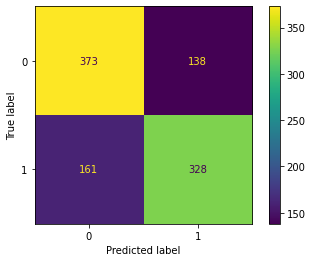

In [23]:
metrics.ConfusionMatrixDisplay(confusion_mtx).plot()

## 4.2 Evaluation with continuous probabilities

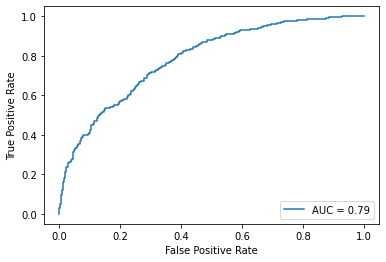

In [24]:
# evaluations using continuous probabilities
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_tf)
roc_auc = metrics.auc(fpr, tpr)
metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()

## 4.3 Inference using PyTorch/Lightning
We can apply the same inference and evaluation techniques to our torch model

In [25]:
# for pytorch/lightning
test_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_test))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
y_pred_torch = []
for batch in test_loader:
    y_pred_torch.append(model_torch(batch[0]).detach().cpu().numpy())
y_pred_torch = np.concatenate(y_pred_torch)

# 5.Model Saving and Loading

In [26]:
# saving a keras model is easy
model_tf.save("trained_tf_model.h5")

In [27]:
# we can also load both the model and its weights from file
model_tf_loaded = tf.keras.models.load_model("trained_tf_model.h5")
model_tf_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv1D)             (None, 200, 32)           928       
                                                                 
 maxpool_1 (MaxPooling1D)    (None, 50, 32)            0         
                                                                 
 gap (GlobalAveragePooling1D  (None, 32)               0         
 )                                                               
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


In [28]:
# by default, pytorch-lightning trainer will automatically save model checkpoints
# see `lightning_logs/version_0/checkpoints`
# we can also manually save pytorch model:
trainer.save_checkpoint("trained_torch_model.ckpt")

In [29]:
# load from pytorch-lightning checkpoint
model_torch_loaded = ModelTorch.load_from_checkpoint("trained_torch_model.ckpt")
model_torch_loaded

ModelTorch(
  (conv1): Sequential(
    (0): Conv1d(4, 32, kernel_size=(7,), stride=(1,), padding=same)
    (1): ReLU()
  )
  (maxpool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc): Sequential(
    (0): Linear(in_features=32, out_features=1, bias=True)
    (1): Sigmoid()
  )
  (criterion): BCELoss()
)

# 6.Extended Practices



6.1 Finish model evaluations for the Torch model.

6.2 Compare the prediction differences between the TF model and Torch model. Do they tend to make mistakes at the same sequences/datapoints?

6.3 Explore and implement other callbacks and metrics for your model, using your preferred deep-learning framework. In particular, early-stopper, model checkpointer, and learning-rate scheduler are commonly used.

6.4 Explore different optimization hyperparameters; e.g., change the optimizer from ADAM to SGD, tune the learning rate from $\{0.1, 0.01, 0.001\}$, and increase/decrease batch sizes.

6.5 Explore different network architectures (changing the convolution/pool sizes, add/delete a layer) of your model.